<h2>Классификация типа 2</h2>

In [4]:
import tensorflow as tf
from tensorflow import keras as ks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as stl
stl.use("ggplot")
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
os.getcwd()

'D:\\DSTU\\практика ИИ\\PokemonNet\\net\\notebooks'

In [8]:
os.chdir('..')

<h3>Чистка датасета</h3>

In [9]:
data = pd.read_csv('datasets/pokemon.csv')
data.shape

(801, 41)

In [10]:
data = data[["name","type1","type2"]]
data = data.sort_values(by=['name'], ascending=True).reset_index(drop=True)

In [11]:
data['name'] = data['name'].str.lower()

In [12]:
data

,name,type1,type2
0,abomasnow,grass,ice
1,abra,psychic,NaN
2,absol,dark,NaN
3,accelgor,bug,NaN
4,aegislash,steel,ghost
...,...,...,...
796,zoroark,dark,NaN
797,zorua,dark,NaN
798,zubat,poison,flying
799,zweilous,dark,dragon


In [13]:
print(data.type2.isna().sum())
print(data.type1.isna().sum())

384
0


In [14]:
data.type1.value_counts()[:5]

type1
water      114
normal     105
grass       78
bug         72
psychic     53
Name: count, dtype: int64

In [15]:
most_common = ['water', 'normal', 'grass', 'bug', 'psychic']
data.type1 = data.type1[data.type1.isin(most_common)]
data

,name,type1,type2
0,abomasnow,grass,ice
1,abra,psychic,NaN
2,absol,NaN,NaN
3,accelgor,bug,NaN
4,aegislash,NaN,ghost
...,...,...,...
796,zoroark,NaN,NaN
797,zorua,NaN,NaN
798,zubat,NaN,flying
799,zweilous,NaN,dragon


<h4>Если у покемона нет вторичного типа, но есть первичный, он присваивается и вторичному типу</h4>

In [16]:
data['type2'] = data['type2'].fillna(data['type1'])
data

,name,type1,type2
0,abomasnow,grass,ice
1,abra,psychic,psychic
2,absol,NaN,NaN
3,accelgor,bug,bug
4,aegislash,NaN,ghost
...,...,...,...
796,zoroark,NaN,NaN
797,zorua,NaN,NaN
798,zubat,NaN,flying
799,zweilous,NaN,dragon


In [17]:
data['type2'].isna().sum()

172

In [18]:
data['type2'] = data['type2'].fillna('None')
data['type2'].isna().sum()

0

<h4>Для классификации будем использоваться 5 самых часто встречающихся типов</h4>

In [19]:
NUM_CLASSES = 5
most_common = data['type2'].value_counts()[:NUM_CLASSES].keys()
most_common = most_common.tolist()
with open('models/type2/class_names.txt', mode='w') as f:
    f.write("\n".join(most_common) + "\n")
print(most_common)

['None', 'flying', 'water', 'normal', 'psychic']


In [20]:
def to_common(x):
    if x not in most_common:
        return most_common[np.random.randint(NUM_CLASSES)]
    else:
        return x
data.type2 = data.type2.apply(lambda x: to_common(x))

In [21]:
data.type2.value_counts()

type2
None       248
flying     155
psychic    134
normal     132
water      132
Name: count, dtype: int64

In [22]:
data.drop('type1', axis=1, inplace=True)
data

,name,type2
0,abomasnow,flying
1,abra,psychic
2,absol,None
3,accelgor,normal
4,aegislash,flying
...,...,...
796,zoroark,None
797,zorua,None
798,zubat,flying
799,zweilous,flying


Text(0, 0.5, 'Число изображений')

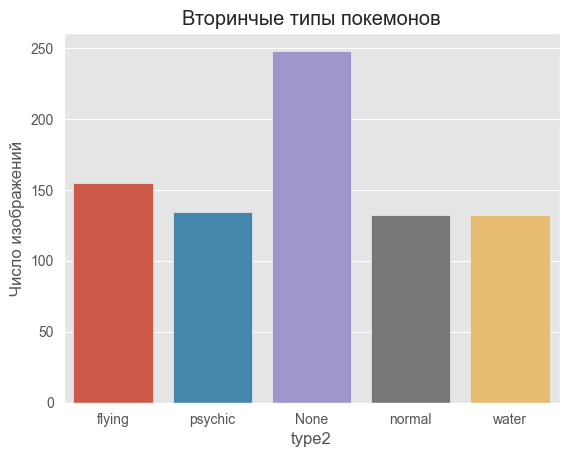

In [23]:
sns.countplot(x=data.type2, hue='type2', data=data,)
plt.title('Вторинчые типы покемонов')
plt.ylabel('Число изображений')

<h4>Создаем датасет на основе расположения изображений</h4>

In [101]:
path='images/'
img_name = sorted(os.listdir(path))
img_paths = []
for i in img_name:
    name = i.split('.')[0]
    img_paths.append({'name': name, 'path': path + i})
image_df = pd.DataFrame(img_paths)

In [102]:
# Сопостовляем новый датасет с исходным
data=data.merge(image_df,how='inner', on='name')

In [103]:
data

,name,type2,path
0,abomasnow,psychic,images/abomasnow.png
1,abra,psychic,images/abra.png
2,absol,None,images/absol.png
3,accelgor,water,images/accelgor.png
4,aerodactyl,flying,images/aerodactyl.png
...,...,...,...
764,zigzagoon,normal,images/zigzagoon.png
765,zoroark,None,images/zoroark.png
766,zorua,None,images/zorua.png
767,zubat,flying,images/zubat.png


<h4>Аугментируем изображения датасета с помощью генератора</h4>

In [108]:
train_datagenerator = ImageDataGenerator(
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)
# Генератор из обучающего датасета
train_generator = train_datagenerator.flow_from_dataframe(
    data,
    x_col='path',
    y_col='type2',
    target_size=(120, 120),
    color_mode='rgba',
    classes=most_common,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=1,
    subset='training')
# Генератор из тренировочного датасета
validation_generator = train_datagenerator.flow_from_dataframe(
    data ,
    x_col='path',
    y_col='type2',
    target_size=(120, 120),
    color_mode='rgba',
    classes=most_common,
    class_mode='categorical',
    batch_size=4,
    shuffle=True,
    seed=1,
    subset='validation'
)

Found 616 validated image filenames belonging to 5 classes.
Found 153 validated image filenames belonging to 5 classes.


<h4>Модель сверточной сети: <u>D + (CV + MP)^3 + DO + F + D + S</u></h4>

In [109]:
model = ks.models.Sequential()
model.add(ks.layers.Dense(4, input_shape=(120, 120, 4)))

model.add(ks.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))

model.add(ks.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))

model.add(ks.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))

model.add(ks.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))
model.add(ks.layers.Dropout(0.2))

model.add(ks.layers.Flatten())

model.add(ks.layers.Dense(1024, activation='relu'))

model.add(ks.layers.Dense(NUM_CLASSES, activation='softmax'))

In [110]:
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 120, 120, 4)    │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 118, 118, 64)   │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 57, 57, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,664,921 (55.94 MB)

 Trainable params: 14,664,921 (55.94 MB)

 Non-trainable params: 0 (0.00 B)

<h4>Обучаем модель на 50 эпохах</h4>

In [111]:
EPOCHS = 50
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 720ms/step - accuracy: 0.2153 - loss: 1.6496 - val_accuracy: 0.2941 - val_loss: 1.5873
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 729ms/step - accuracy: 0.3025 - loss: 1.5819 - val_accuracy: 0.2941 - val_loss: 1.5923
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 855ms/step - accuracy: 0.3021 - loss: 1.5858 - val_accuracy: 0.2941 - val_loss: 1.5830
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 977ms/step - accuracy: 0.2915 - loss: 1.5844 - val_accuracy: 0.2941 - val_loss: 1.5846
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 819ms/step - accuracy: 0.2941 - loss: 1.5730 - val_accuracy: 0.2941 - val_loss: 1.5976
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 828ms/step - accuracy: 0.2816 - loss: 1.5663 - val_accuracy: 0.2876 - val_loss: 1.6147
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 843ms/step - accuracy: 0.2402 - loss: 1.5852 - val_accuracy: 0.2876 - val_loss: 1.5824
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 827ms/step - accuracy: 0.2963 - loss: 1.5716 - val_accu

<h4>Сохраняем модель и график точности</h4>

In [116]:
model.save('models/type2/best/model.h5')

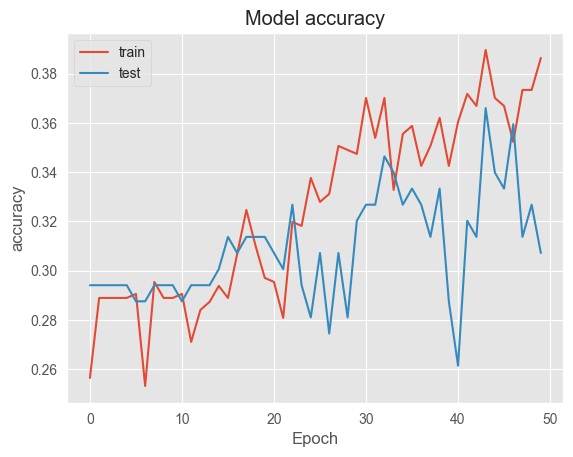

In [117]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.savefig('models/type2/best/accuracy.png')

<h4>Проверяем модель на изображении покемона</h4>

In [118]:
import matplotlib.image as mpimg
def predict(model, image_path):
    image = mpimg.imread(image_path)
    image = np.expand_dims(image, axis=0)
    return model.predict(image)

In [119]:
class_names = most_common
def predict_type1(model, img_path):
    label = img_path.split('/')[-1].split('.')[0]
    prediction = predict(model, img_path)[0]
    result = {class_names[i]: prediction[i] for i in range(len(prediction))}
    print(f'{label} тип 2: {result}')

In [121]:
predict_type1(model, 'images/aipom.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
aipom тип 2: {'None': 0.18648106, 'water': 0.24132223, 'flying': 0.22619332, 'normal': 0.15261114, 'psychic': 0.19339216}
